In [1]:
%matplotlib inline
import numpy as np
import src.io as io
import src.components as cmpnt

/Users/fpoitevi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/fpoitevi/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# 1. Load dataset
We assume that a dataset is made of two files called {keyword}.pdb and {keyword}.id. Given this, only {keyword} needs to be given.

In [2]:
keyword = 'traj'

The former contains the coordinates and the latter the corresponding PDB ids.

In [3]:
traj, ids = io.load_dataset(keyword)

# 2. Component Analyses
We explore the dataset by looking here at its components.

We start by performing a principal component analysis, and examine the whole spectrum (note that by setting `n_components < len(ids)` one could zoom on the first PCs).

## 2.1. PCA

In [4]:
n_components = len(ids)

We extract below the components, the sqrt of their variance, and the coordinates of the dataset along them. We further compute the average and std of the negentropy for each component.

In [5]:
v_pca, l_pca, x_pca = cmpnt.traj2pc(traj,n_components=n_components)
J_ave, J_std = cmpnt.ave_score(x_pca,n_components)

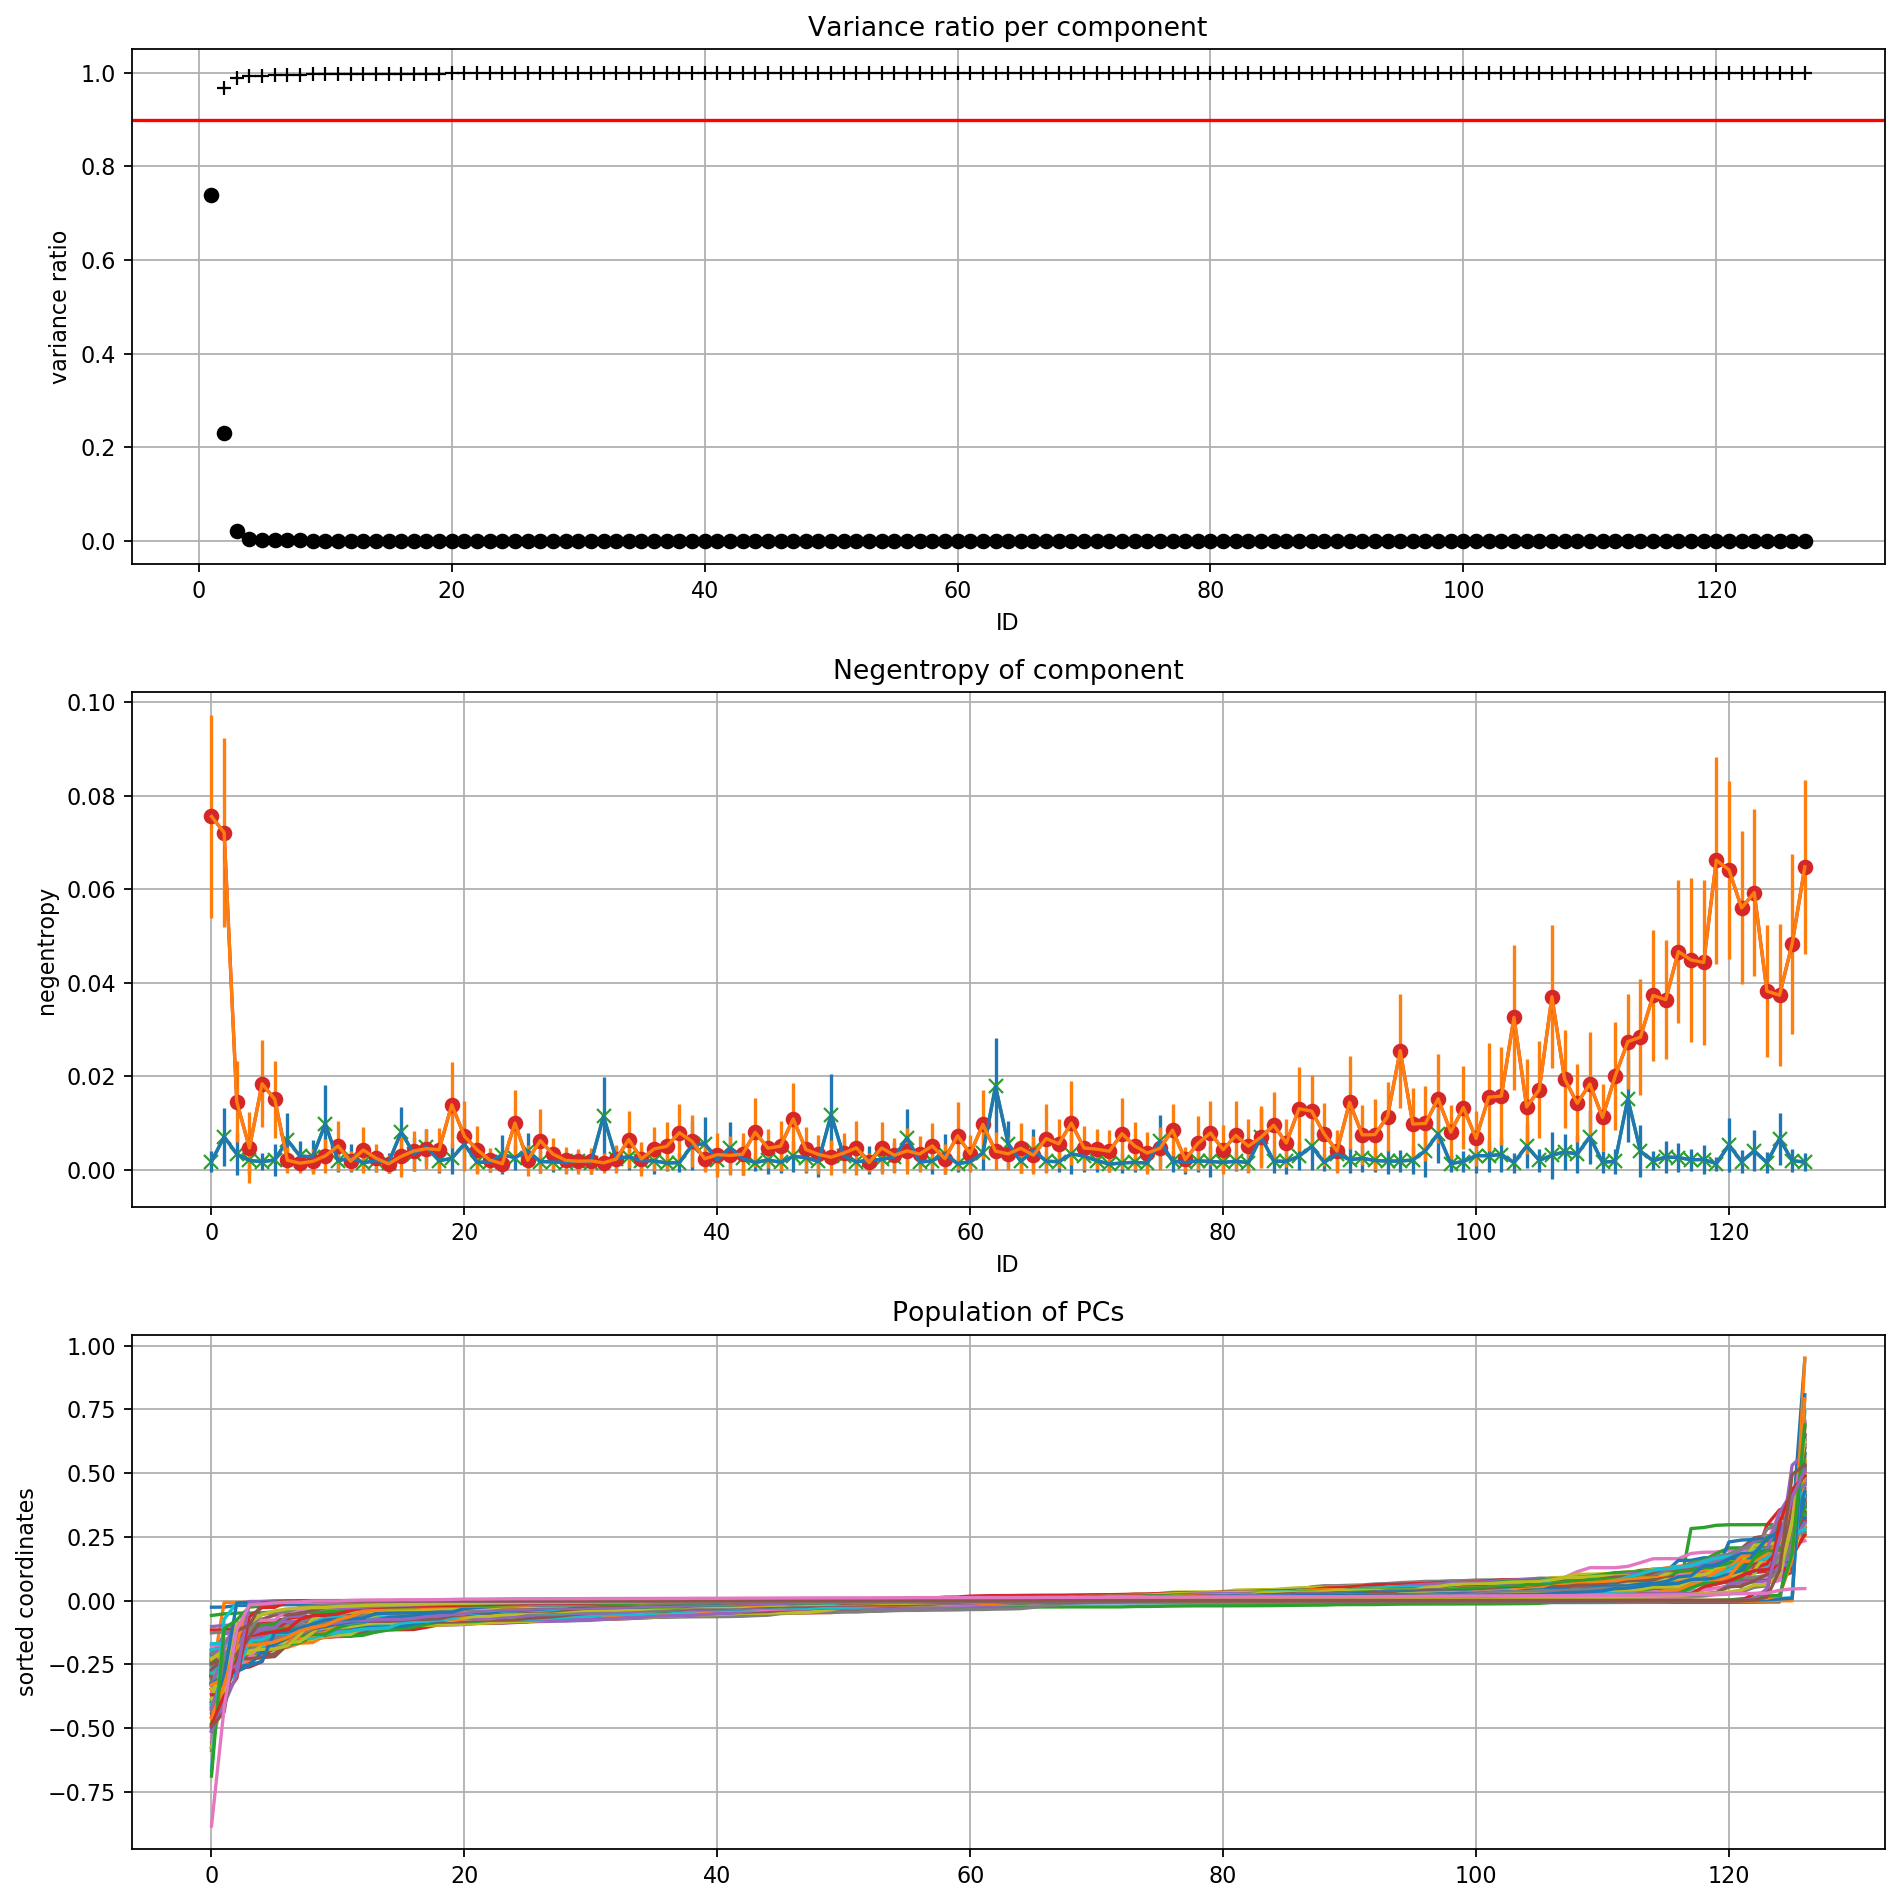

In [6]:
cmpnt.plot_stats_CA(x_pca,l_pca,n_components)

**Figure above**: from top to bottom, we plot *(top)* the variance ratio of each component, together with its cumulated sum along the spectrum (red line is threshold that could be used to reduce dimensionality - we will use it later). *(middle)* the negentropy of the component (in orange) can be compared to that of a random variable (in blue).

**Observation**: we see that the first and last components carry significant negentropy. *(bottom)* we plot the coordinates of the dataset sorted along each (normalized) component.

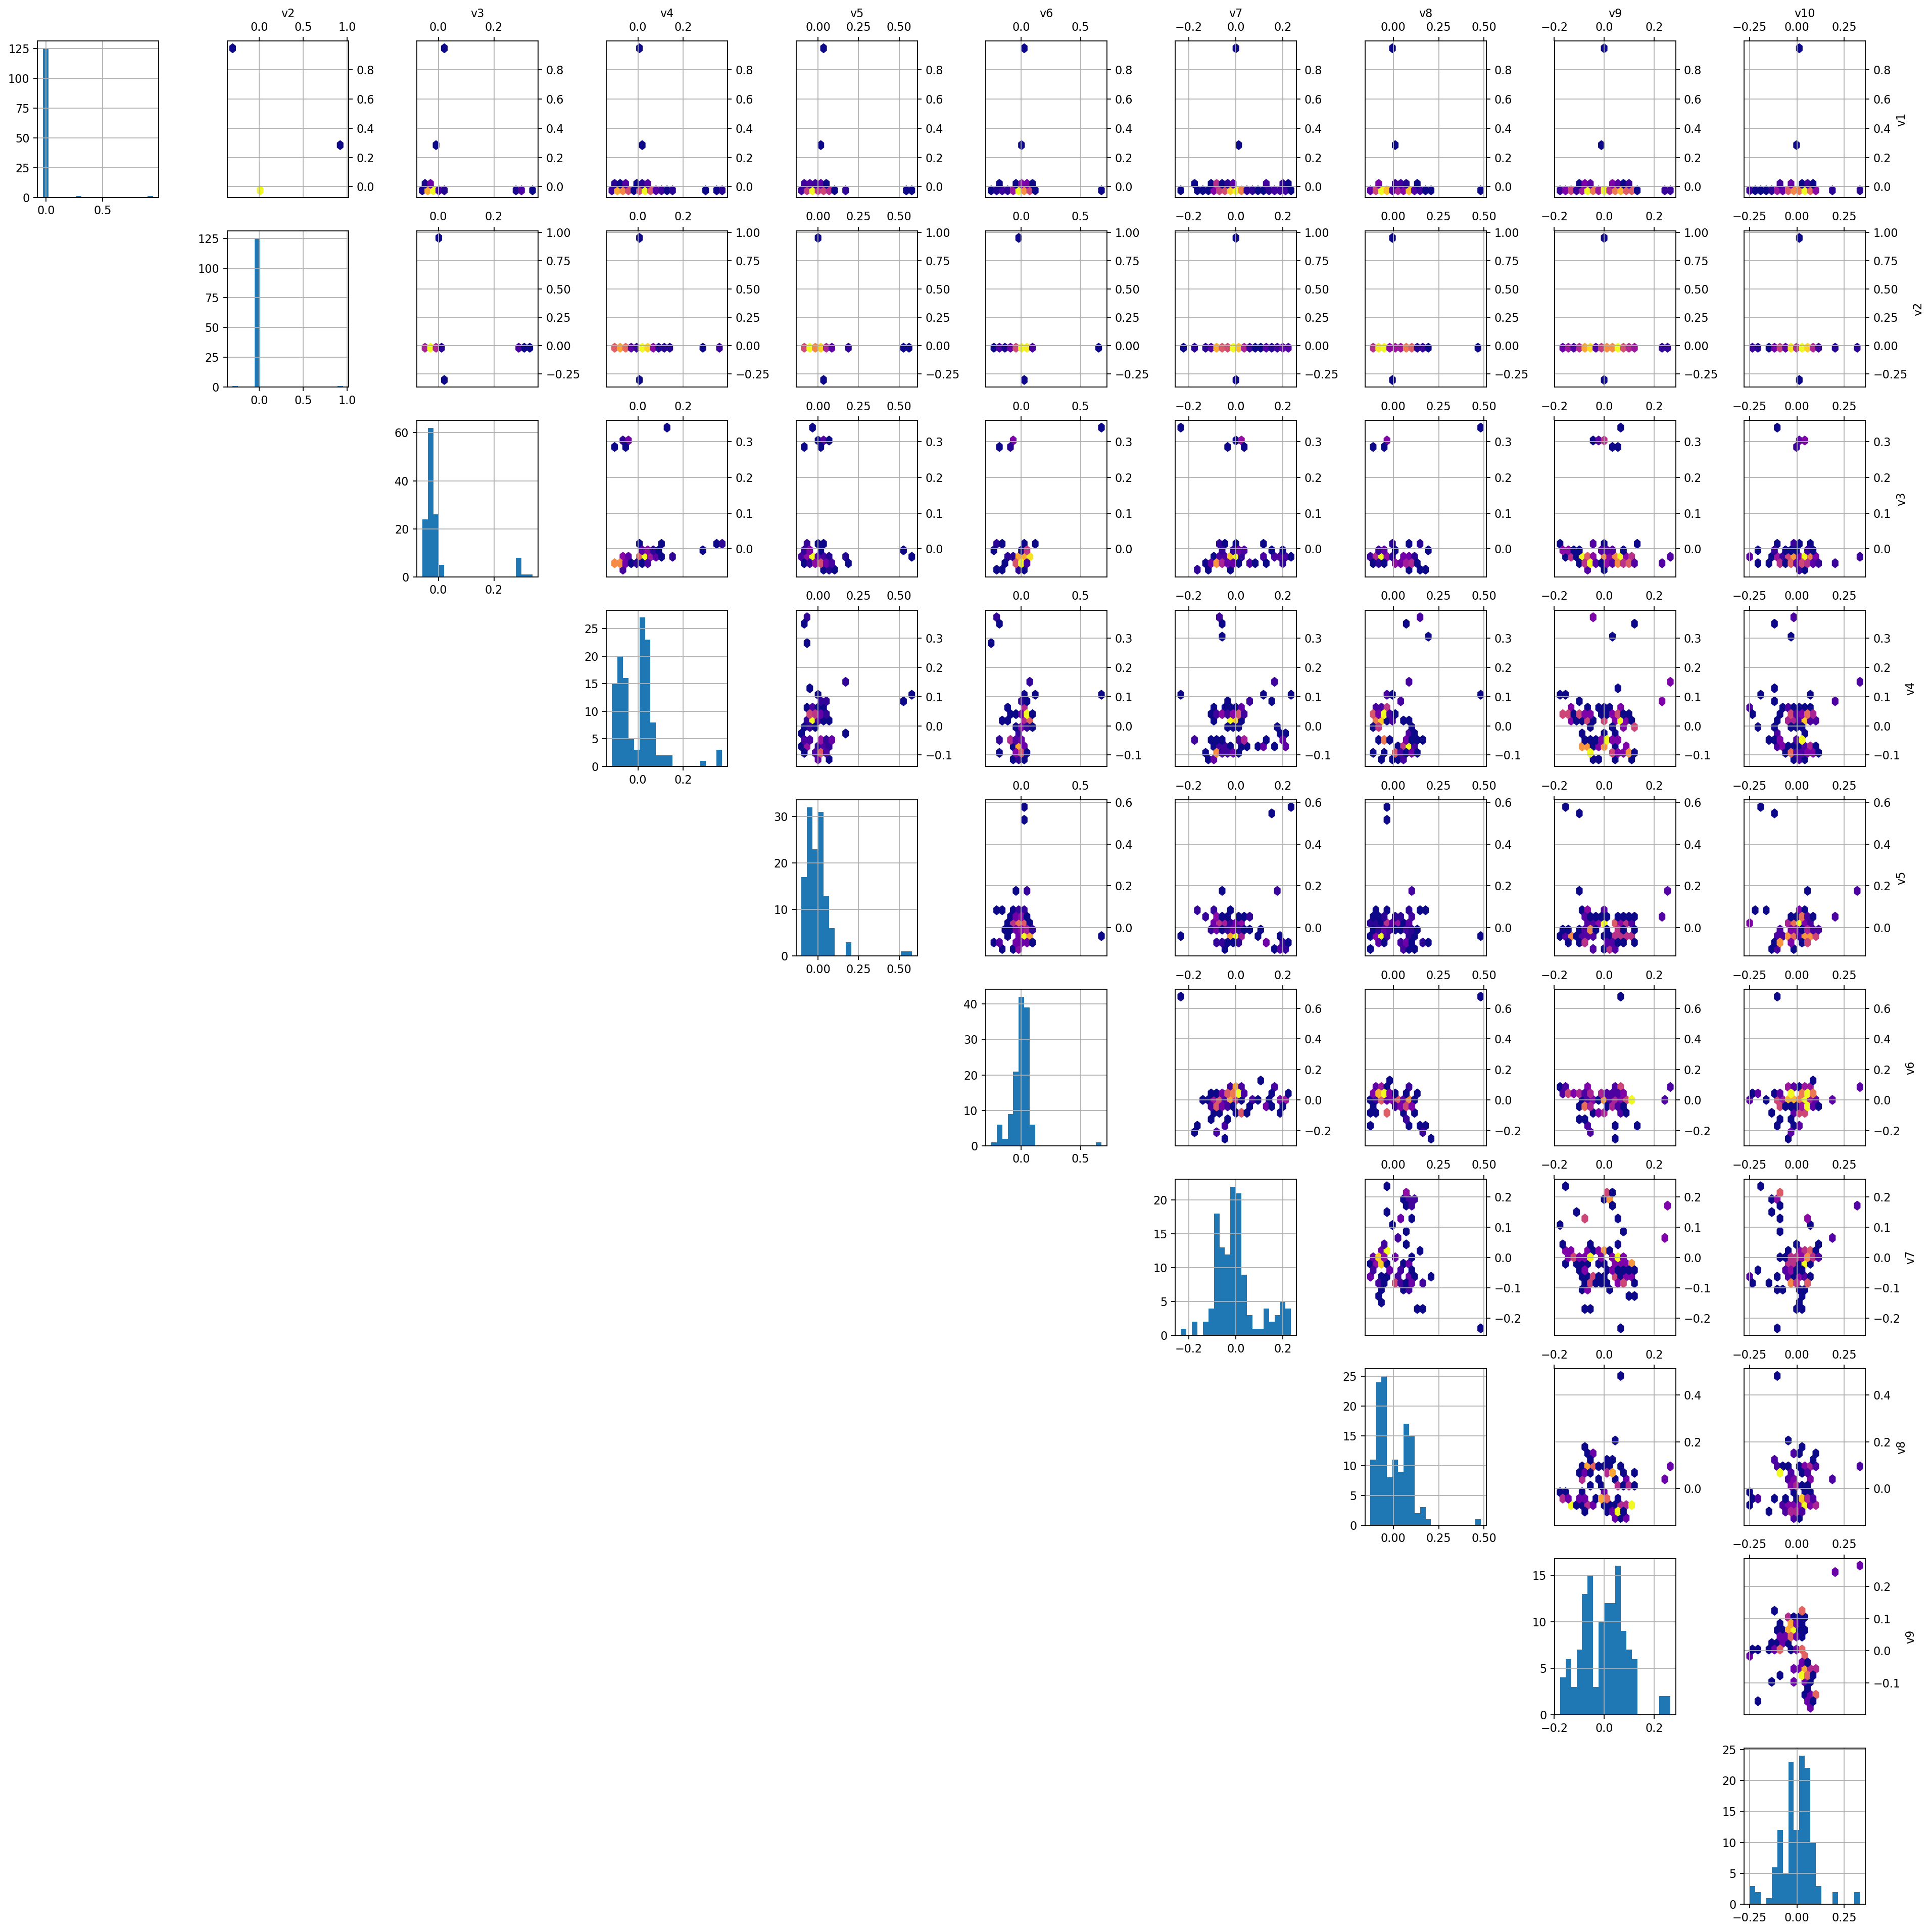

In [7]:
i=0
cmpnt.biplots(x_pca[:,i:len(ids)],n=10,nbins=20,figsize=(24,24))

**Figure above**: We examine the coordinates in the component space, by pairs. On the diagonal, we show the histograms of the projection of the dataset on the corresponding component. Note that one can scan the component spectrum by setting the variables `i` and `n` to the desired values (where the components shown will be from `i+1` to `i+n`).

**Observation**: We see that the first 2 components, who carry significant variance and negentropy, arise because of a few individuals in the dataset  that are very much separated from the rest.

Although in this case, it appears clearly that the 1st principal component (PC1) could be used to identify the 'outliers', we illustrate here how performing ICA could further help. In a nutshell, ICA mixes the PCs so that the projection of the data in the resulting directions is maximally interesting (non-gaussian). It thus matters what PCs we give it in the first place.

## 2.2. ICA

One of several approaches is possible here...
We could either truncate to the first few PCs, or first sort the PCs in order of decreasing negentropy instead of decreasing variance and then truncate to the first few, or we could not truncate at all

### 2.2.1. ICA on whole PC spectrum

/Users/fpoitevi/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


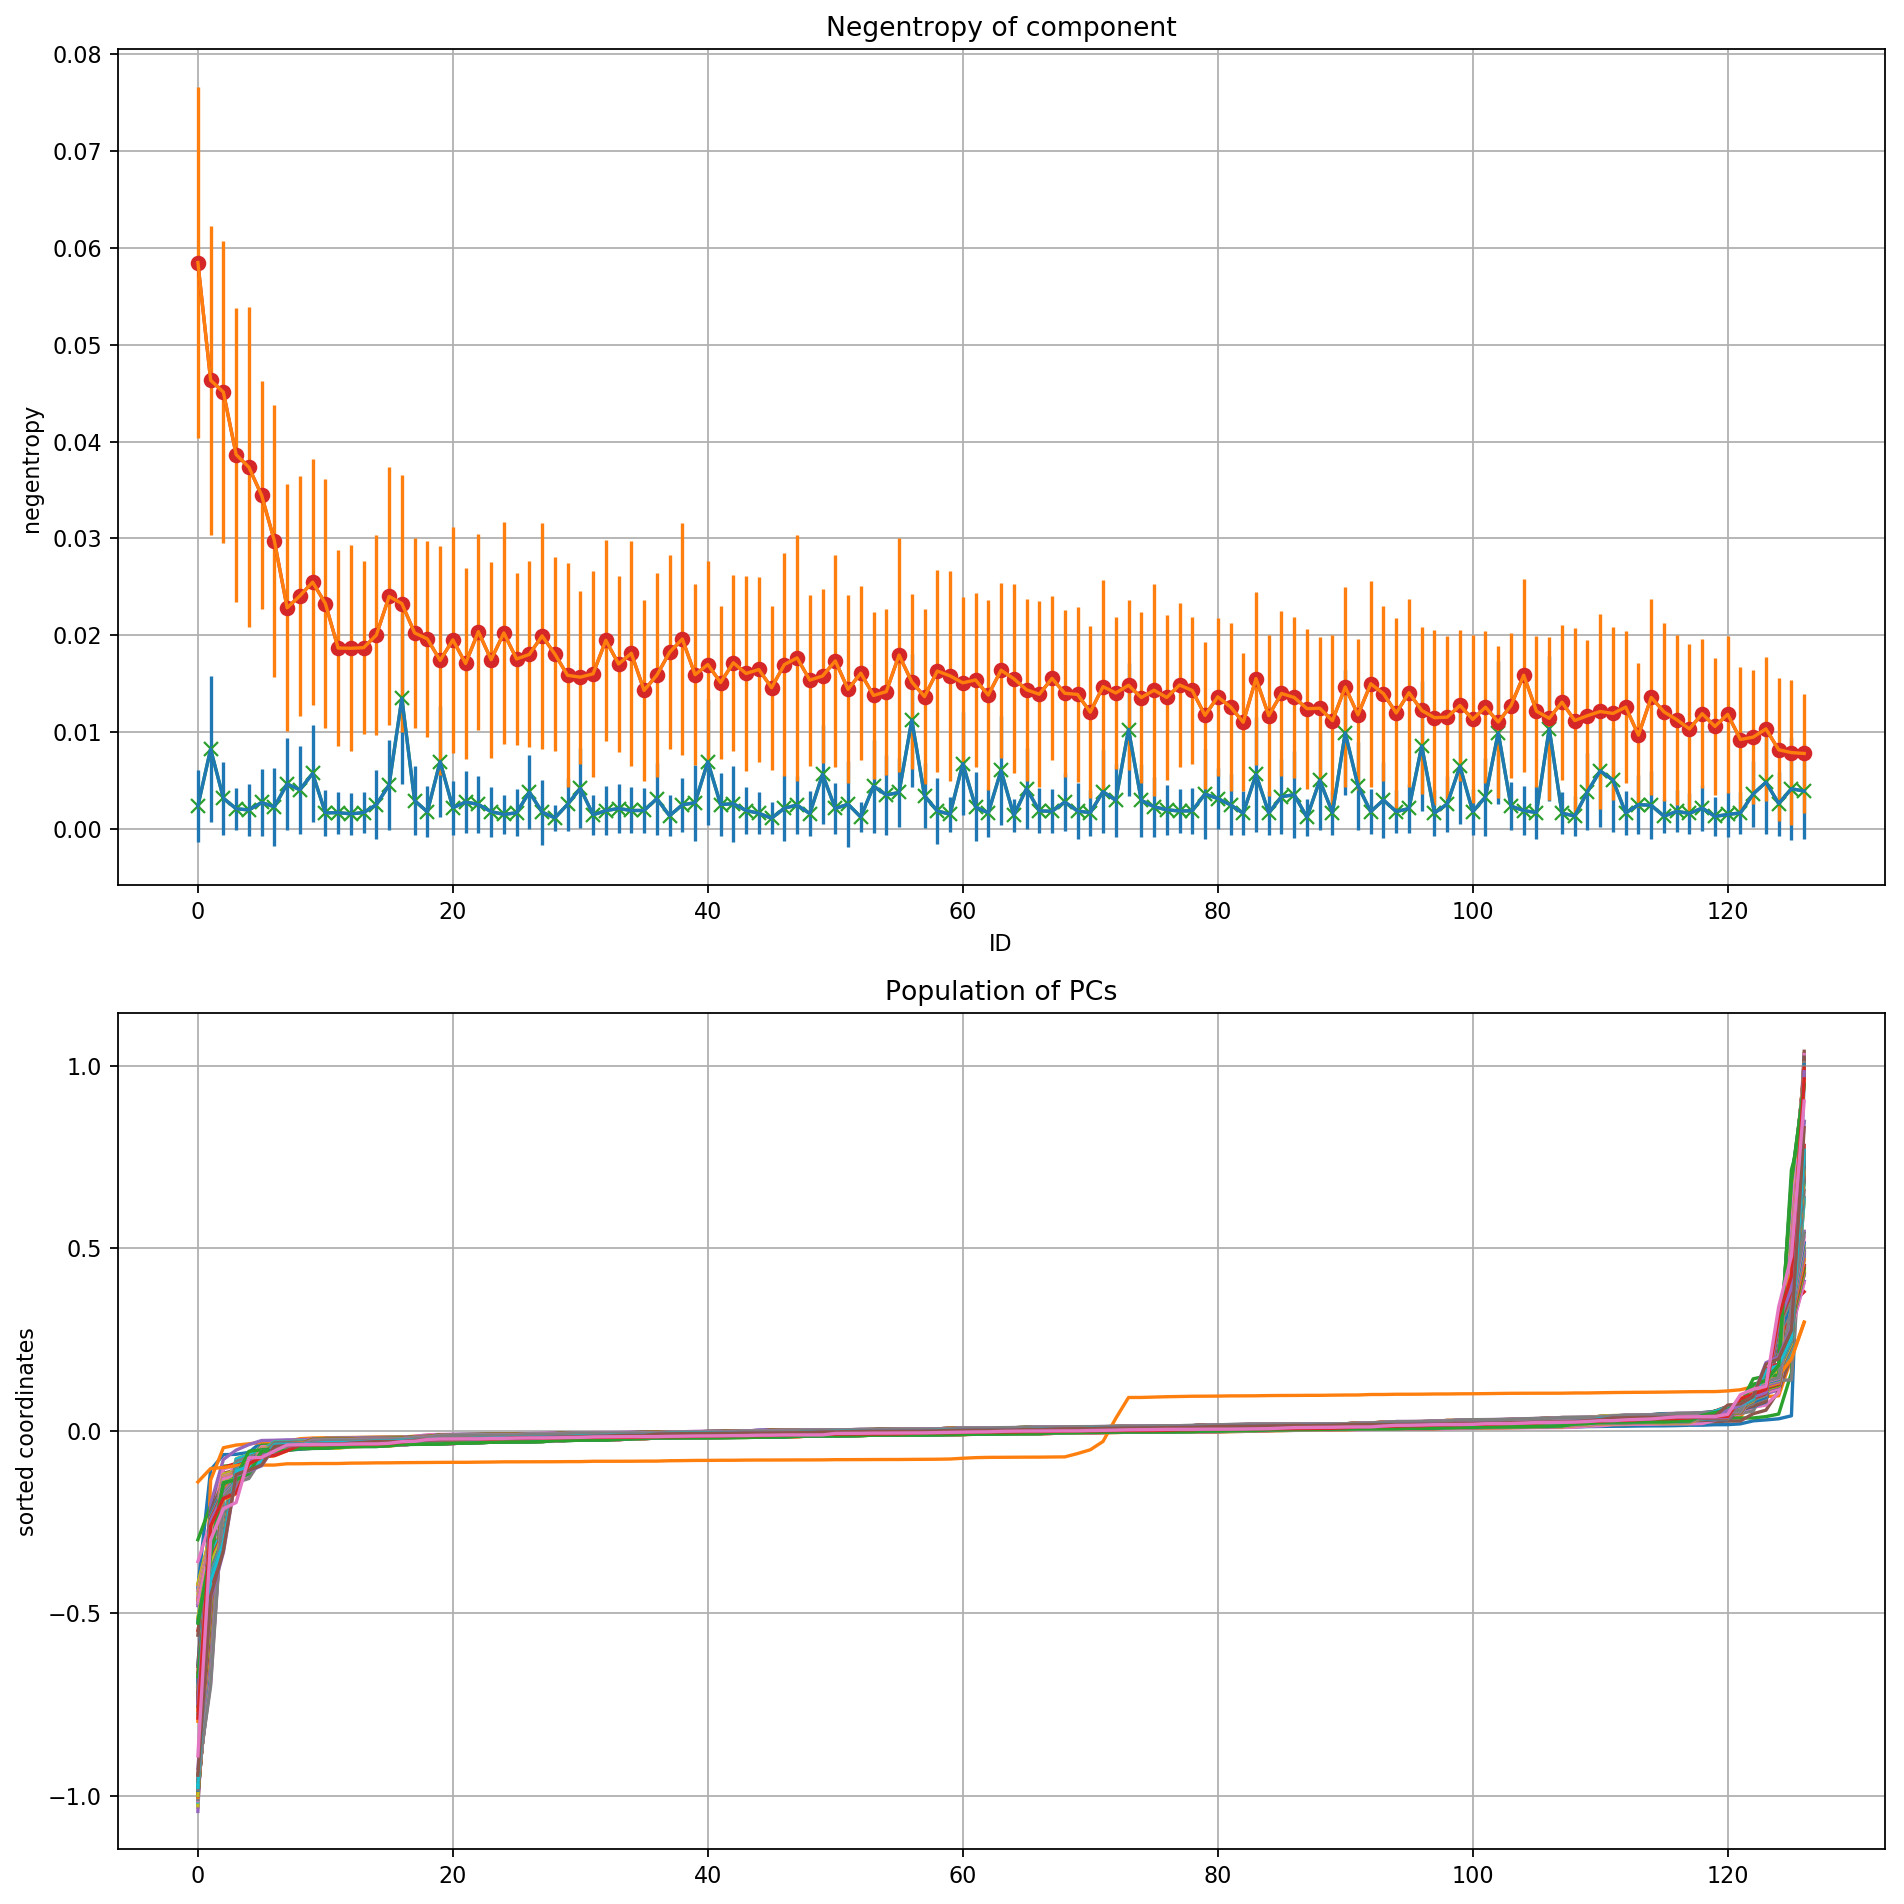

In [8]:
n_ICA = len(ids)
v_pca, l_pca, x_pca = cmpnt.traj2pc(traj, n_components=n_ICA)
v_ica, m_ica, x_ica = cmpnt.traj2ic(x_pca,n_components=n_ICA)
J_ave, J_std = cmpnt.ave_score(x_ica,n_ICA)
cmpnt.plot_stats_CA(x_ica,np.zeros(1),n_ICA)

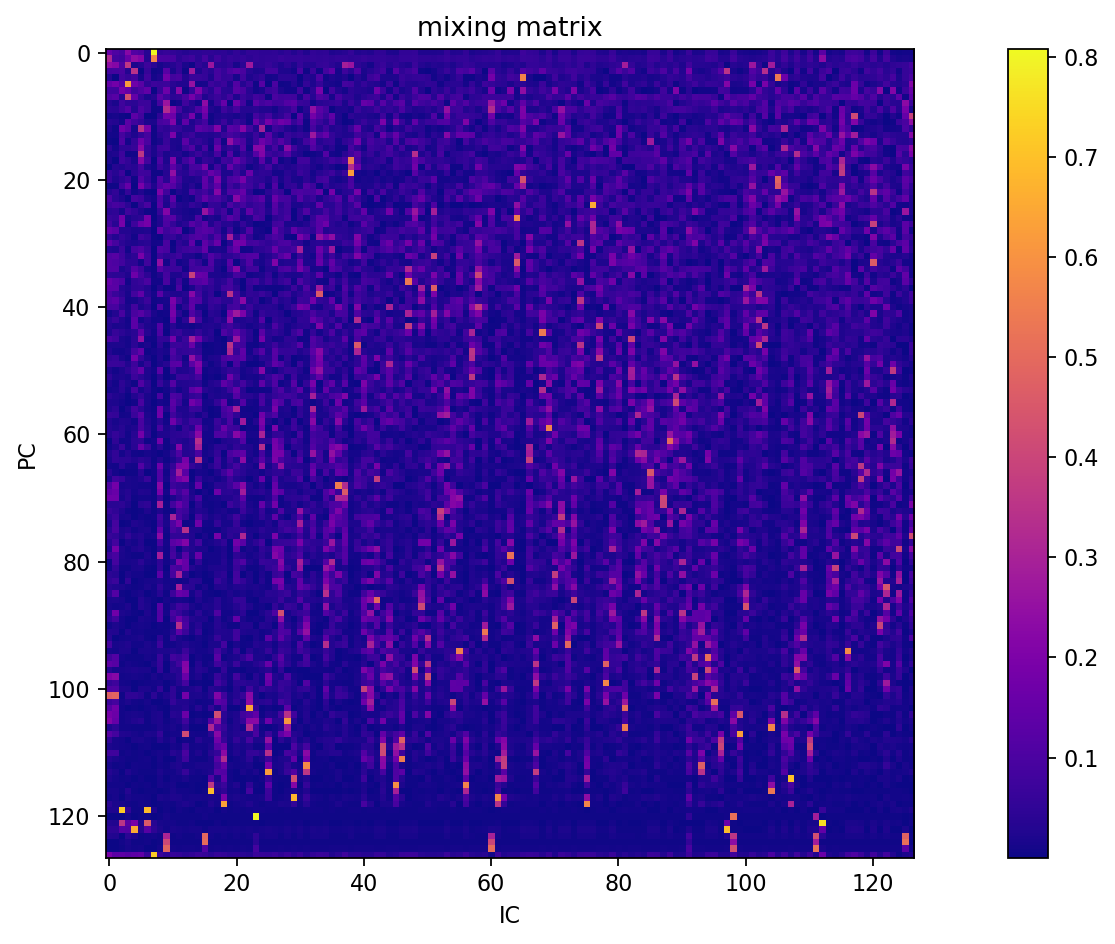

In [9]:
cmpnt.plot_mixing(abs(m_ica))

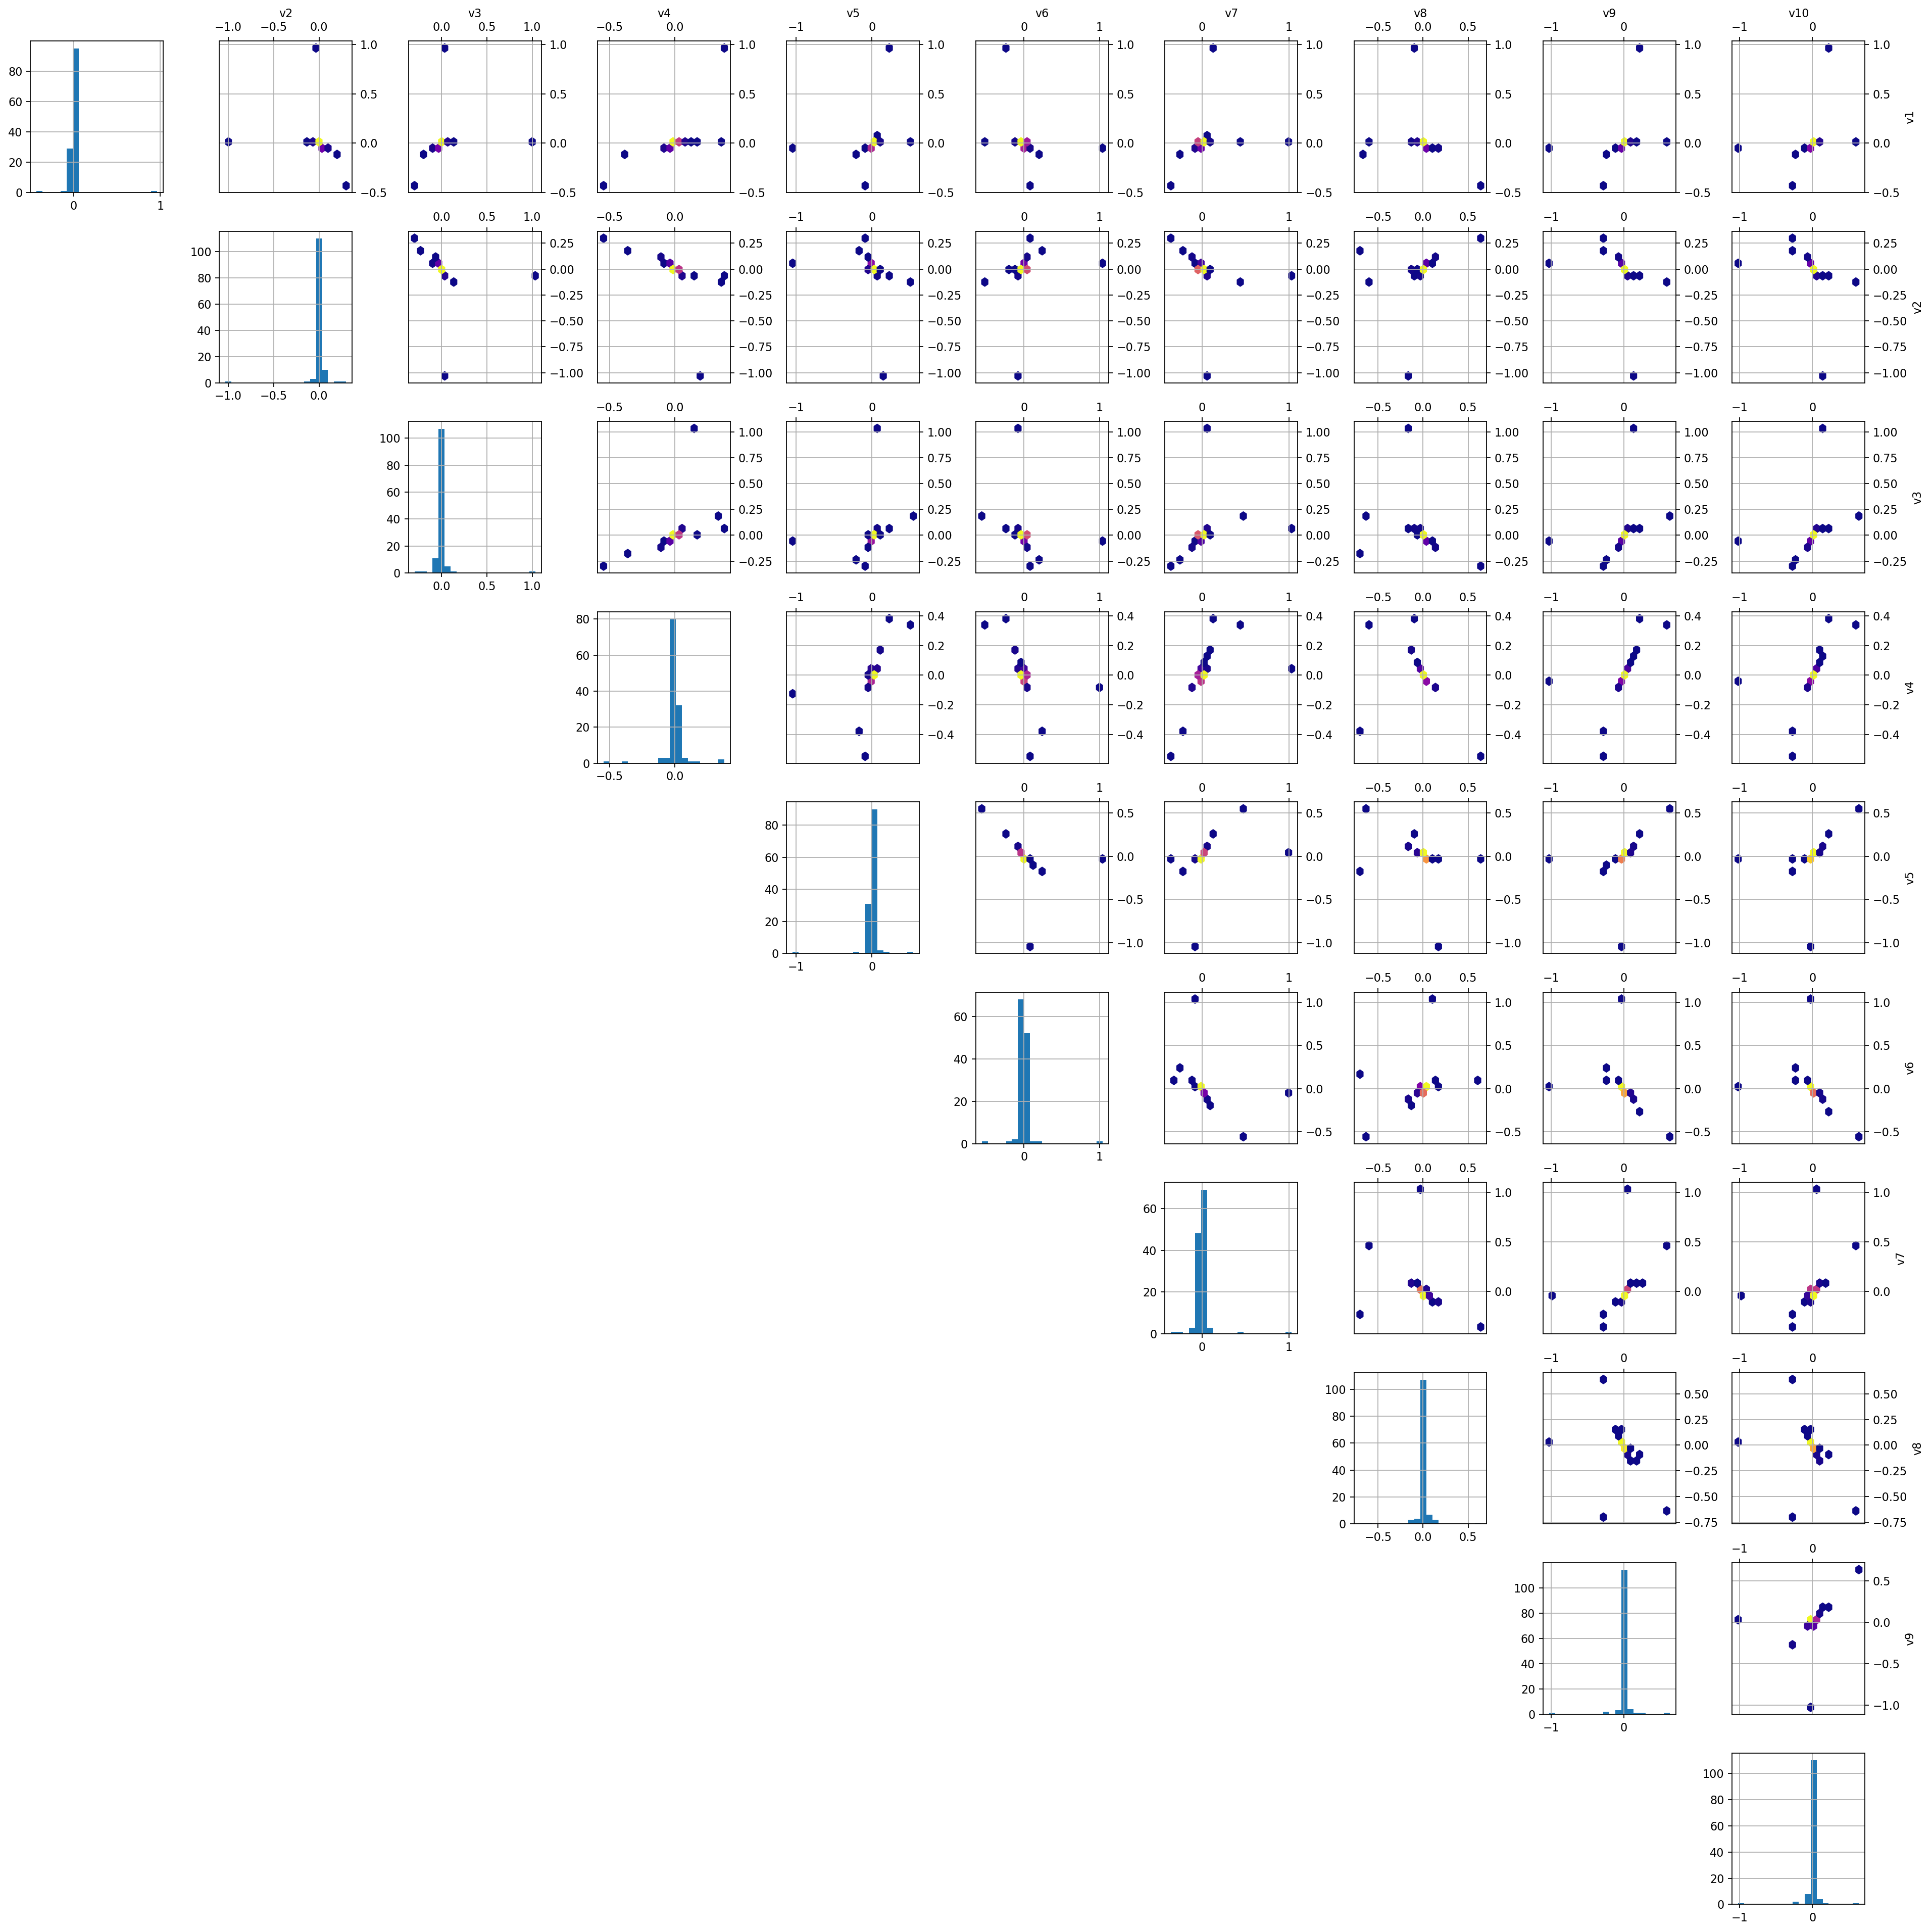

In [10]:
i=0
cmpnt.biplots(x_ica[:,i:len(ids)],n=10,nbins=20,figsize=(24,24))

Feeding in the whole spectrum, we can make a few observations: it seems that the negentropy of all ICs found is significative, no IC seems uninteresting, which is weird. Also, the first ICs mostly carry the first and last PCs, and a lot of the last PCs are each carried by a few ICs (makes sense as the PCs were already high in negentropy).

### 2.2.2. ICA on truncated spectrum
We previously identified that the first few PCs accounted for most of the variance in the data. It would thus be sensible to focus on those.

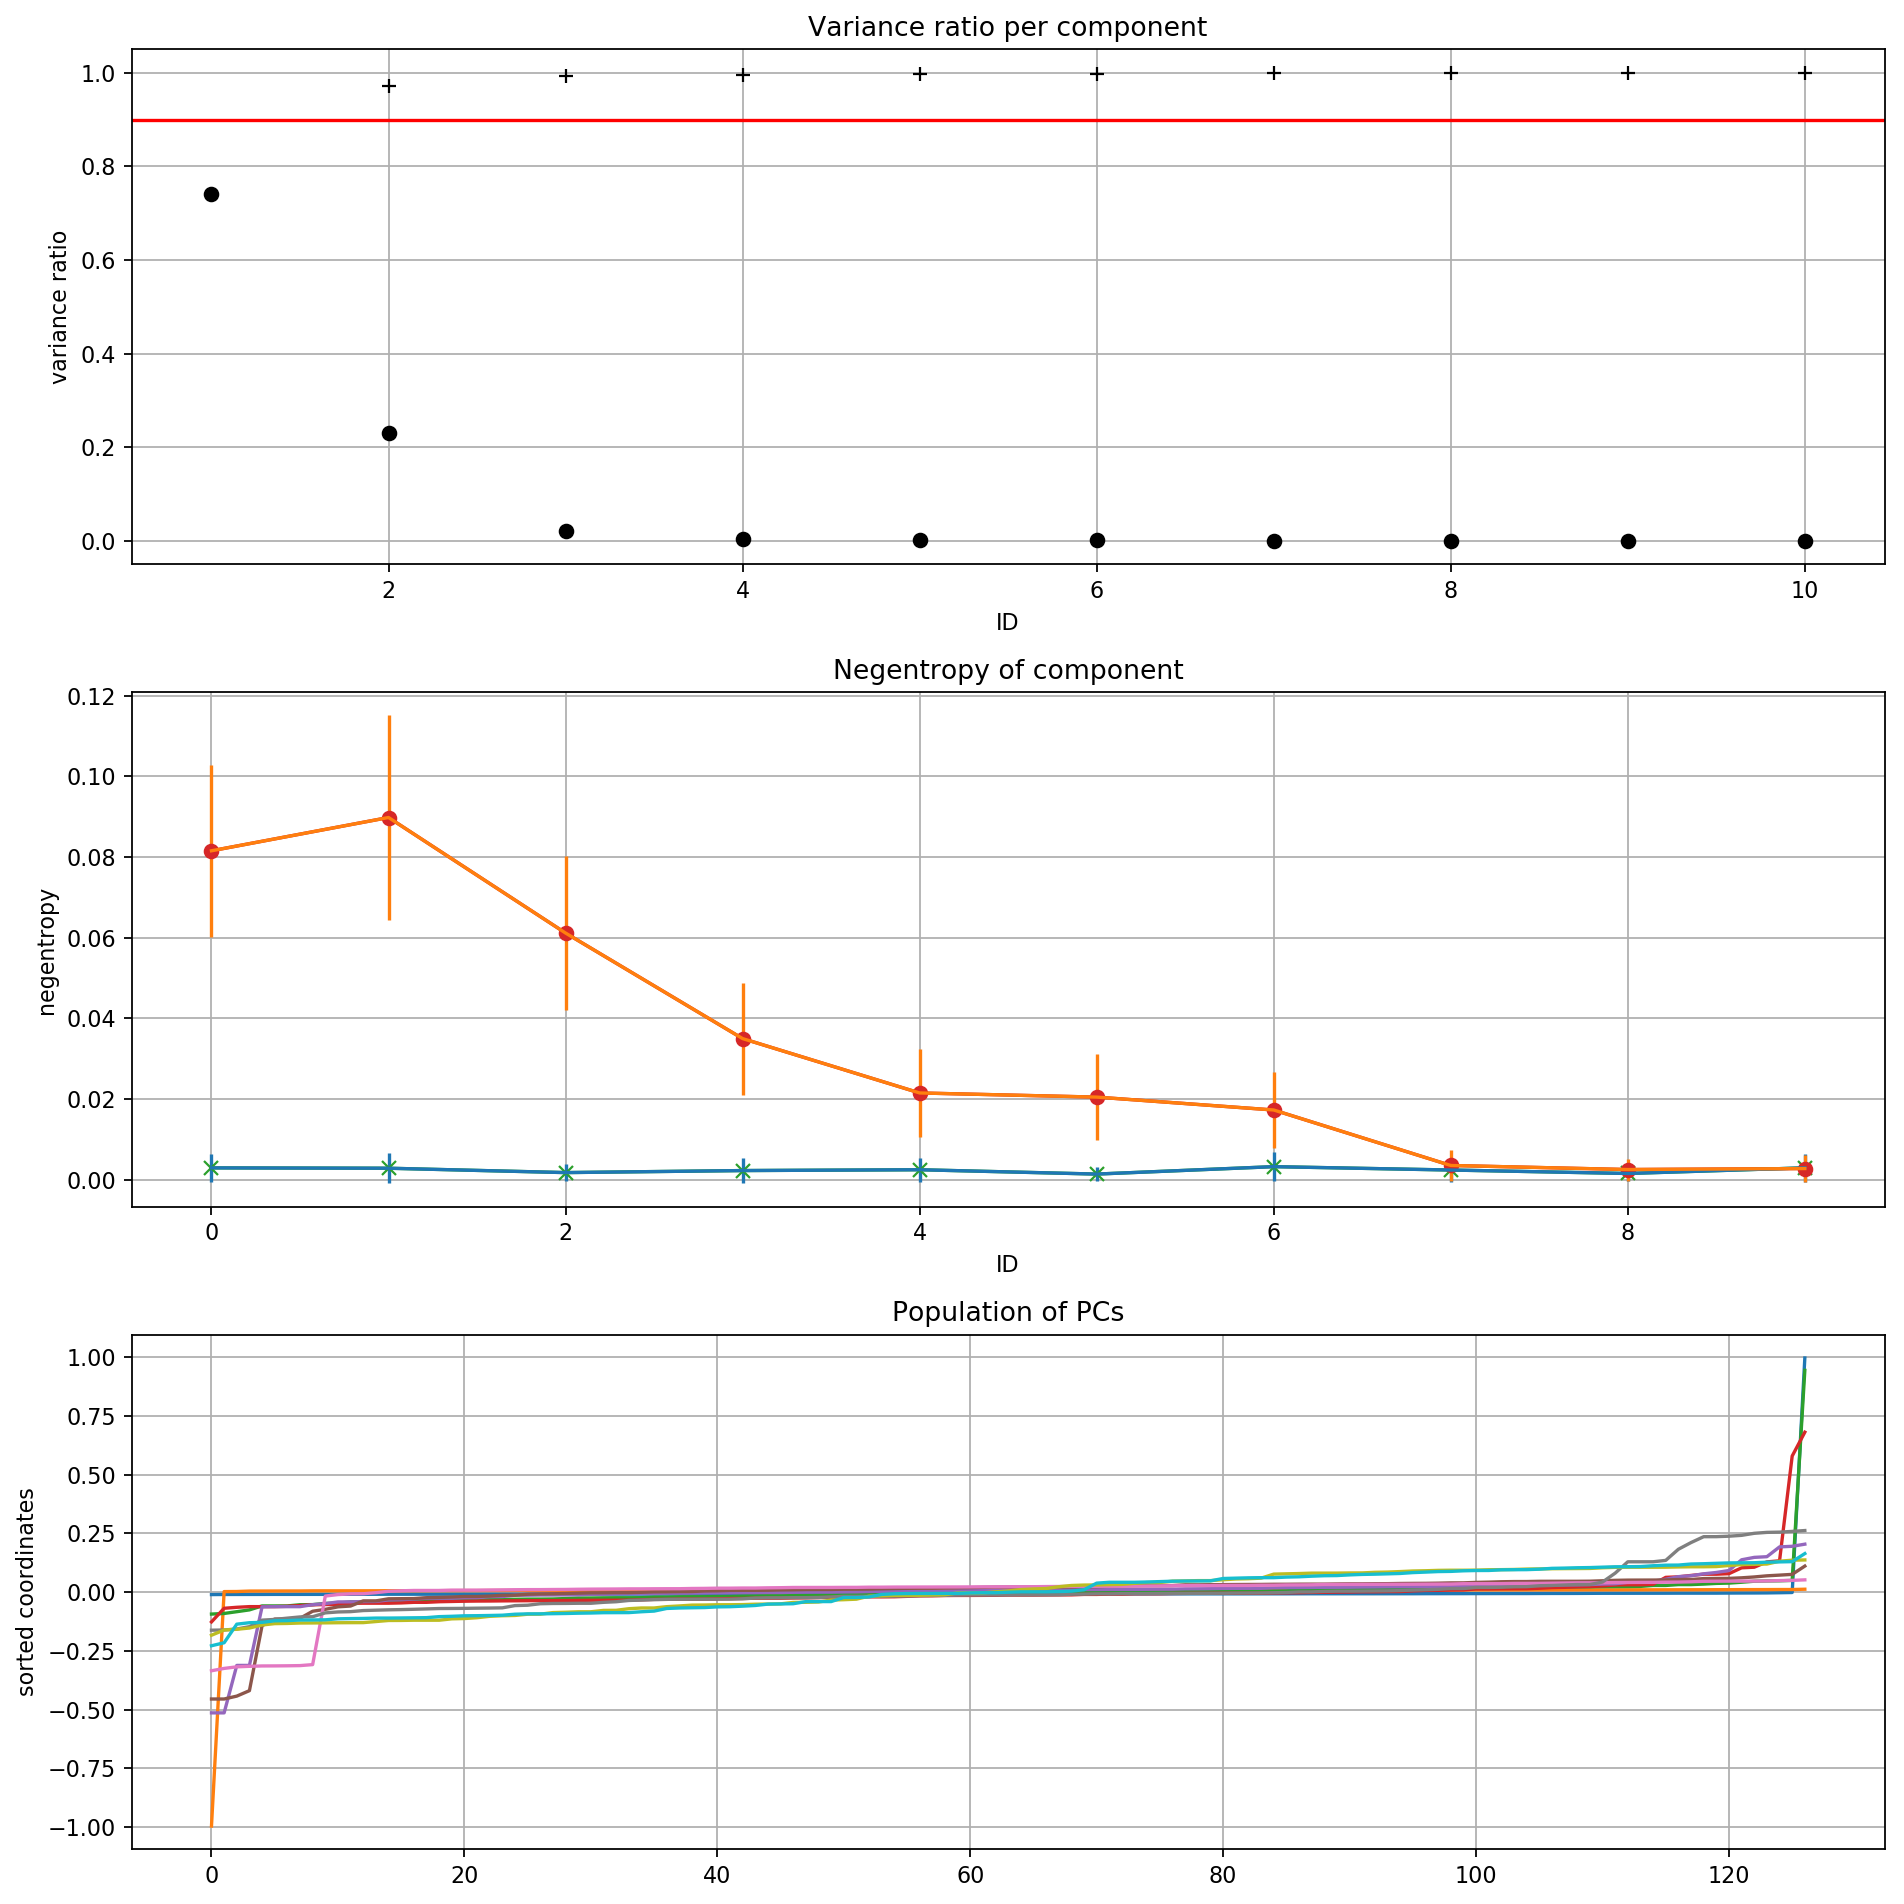

In [11]:
n_ICA = 10
v_pca, l_pca, x_pca = cmpnt.traj2pc(traj, n_components=n_ICA)
v_ica, m_ica, x_ica = cmpnt.traj2ic(x_pca,n_components=n_ICA)
J_ave, J_std = cmpnt.ave_score(x_ica,n_ICA)
cmpnt.plot_stats_CA(x_ica,l_pca,n_ICA)

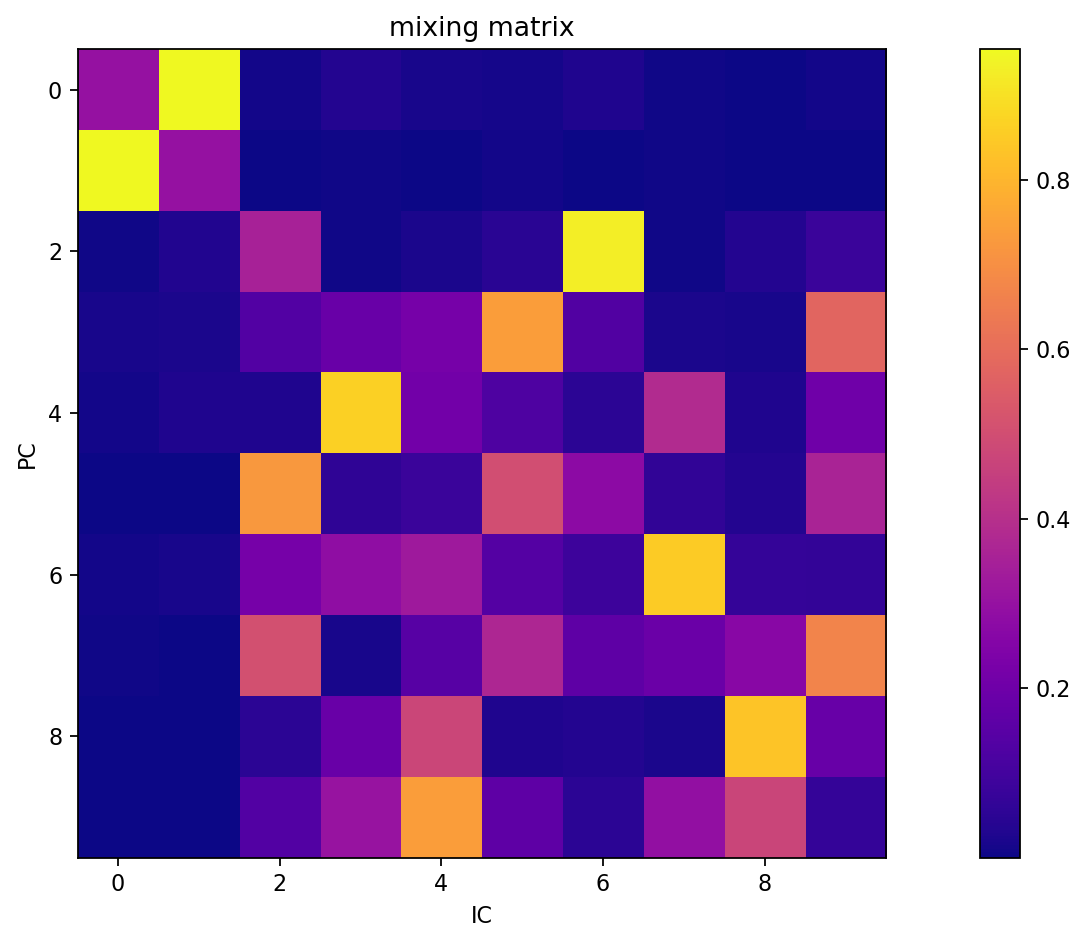

In [12]:
cmpnt.plot_mixing(abs(m_ica))

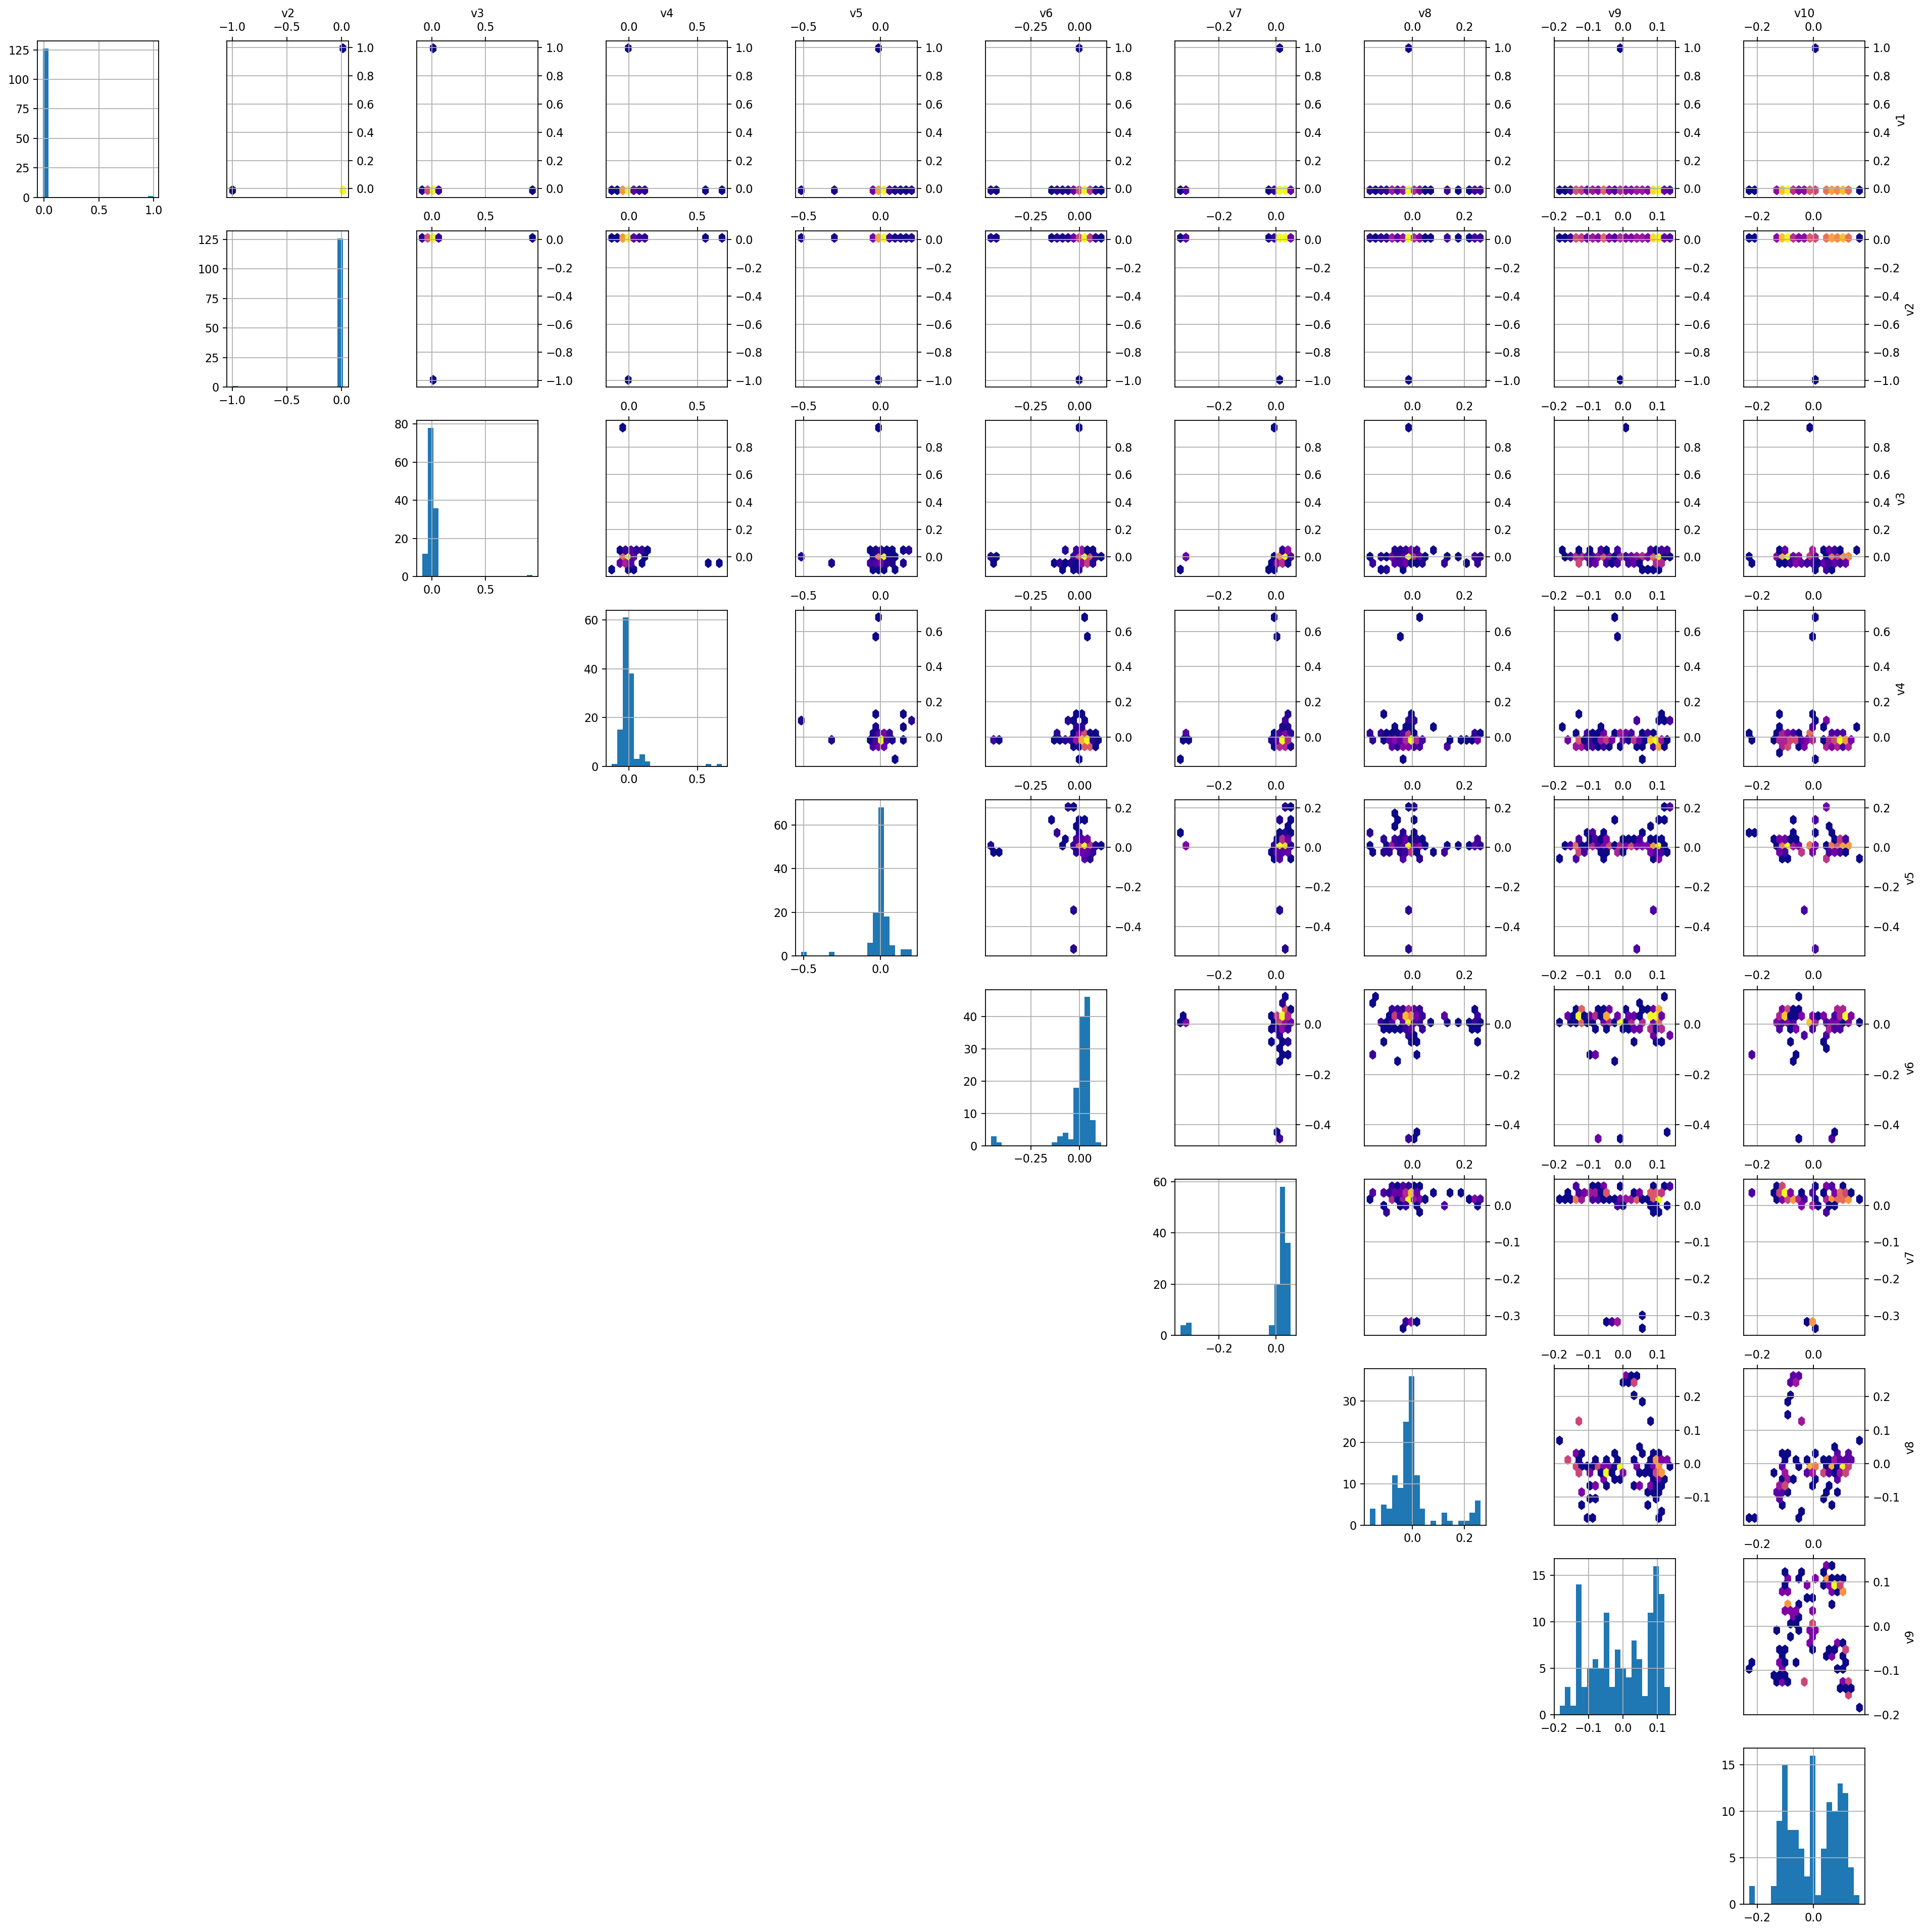

In [13]:
i=0
cmpnt.biplots(x_ica[:,i:len(ids)],n=n_ICA,nbins=20,figsize=(24,24))

We see here that the first two PCs are mixed together (rotated) to give the first two ICs, each well aligned with outliers. The remaining components also seem to align the data well, but interesting clusters seem to appear.

#### sorting PC in decreasing negentropy order first

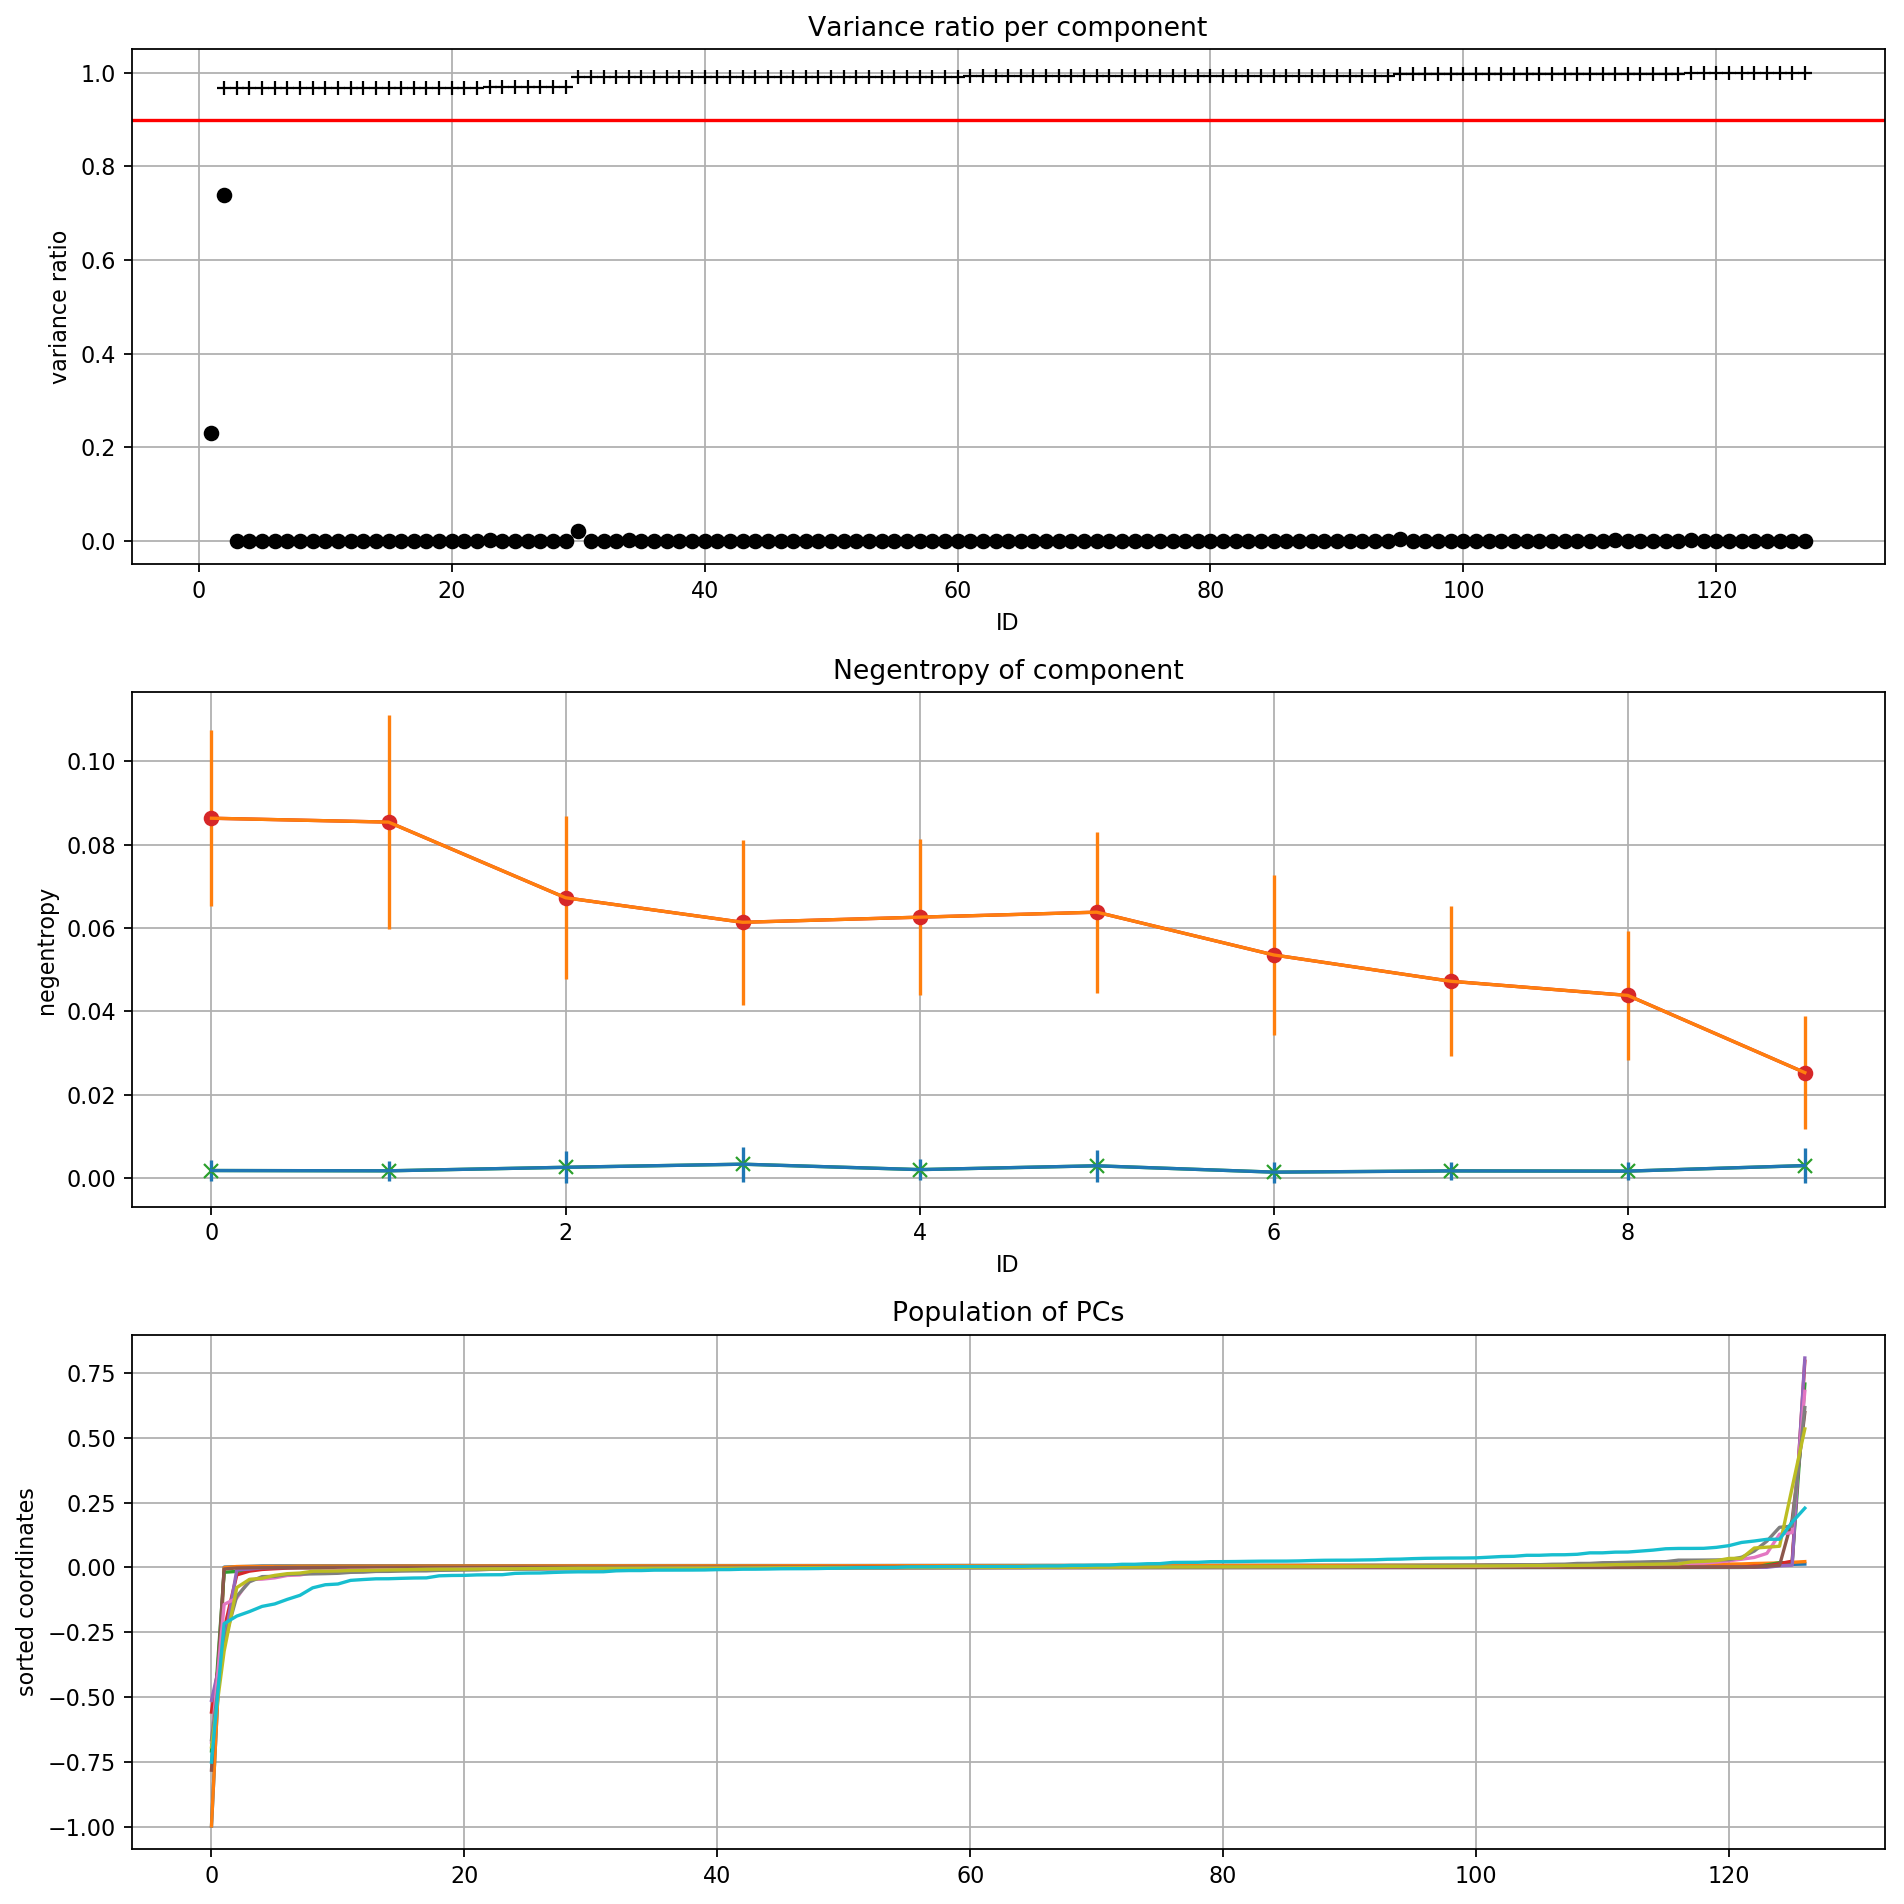

In [14]:
v_pca, l_pca, x_pca = cmpnt.traj2pc(traj, n_components=len(ids),negent_sort=True)
v_ica, m_ica, x_ica = cmpnt.traj2ic(x_pca[:,0:n_ICA],n_components=n_ICA)
J_ave, J_std = cmpnt.ave_score(x_ica,n_ICA)
cmpnt.plot_stats_CA(x_ica,l_pca,n_ICA)

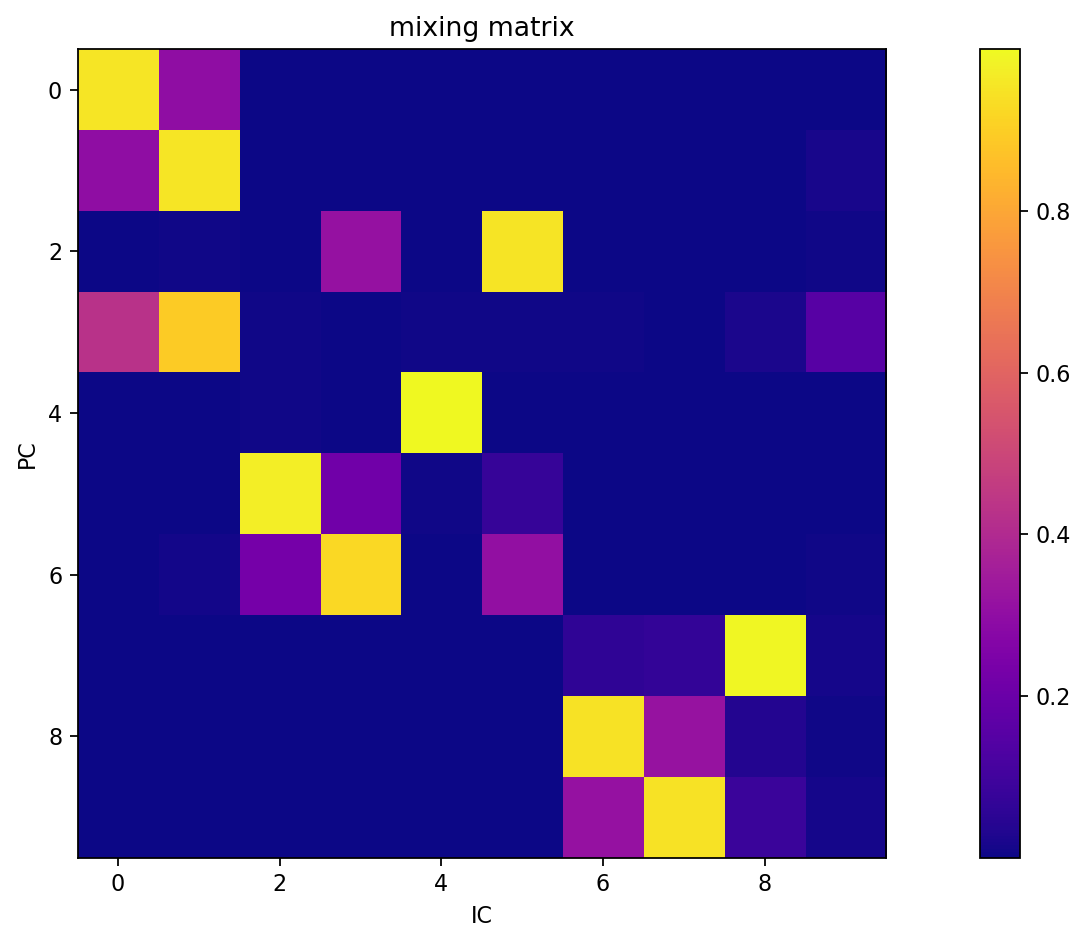

In [15]:
cmpnt.plot_mixing(abs(m_ica))

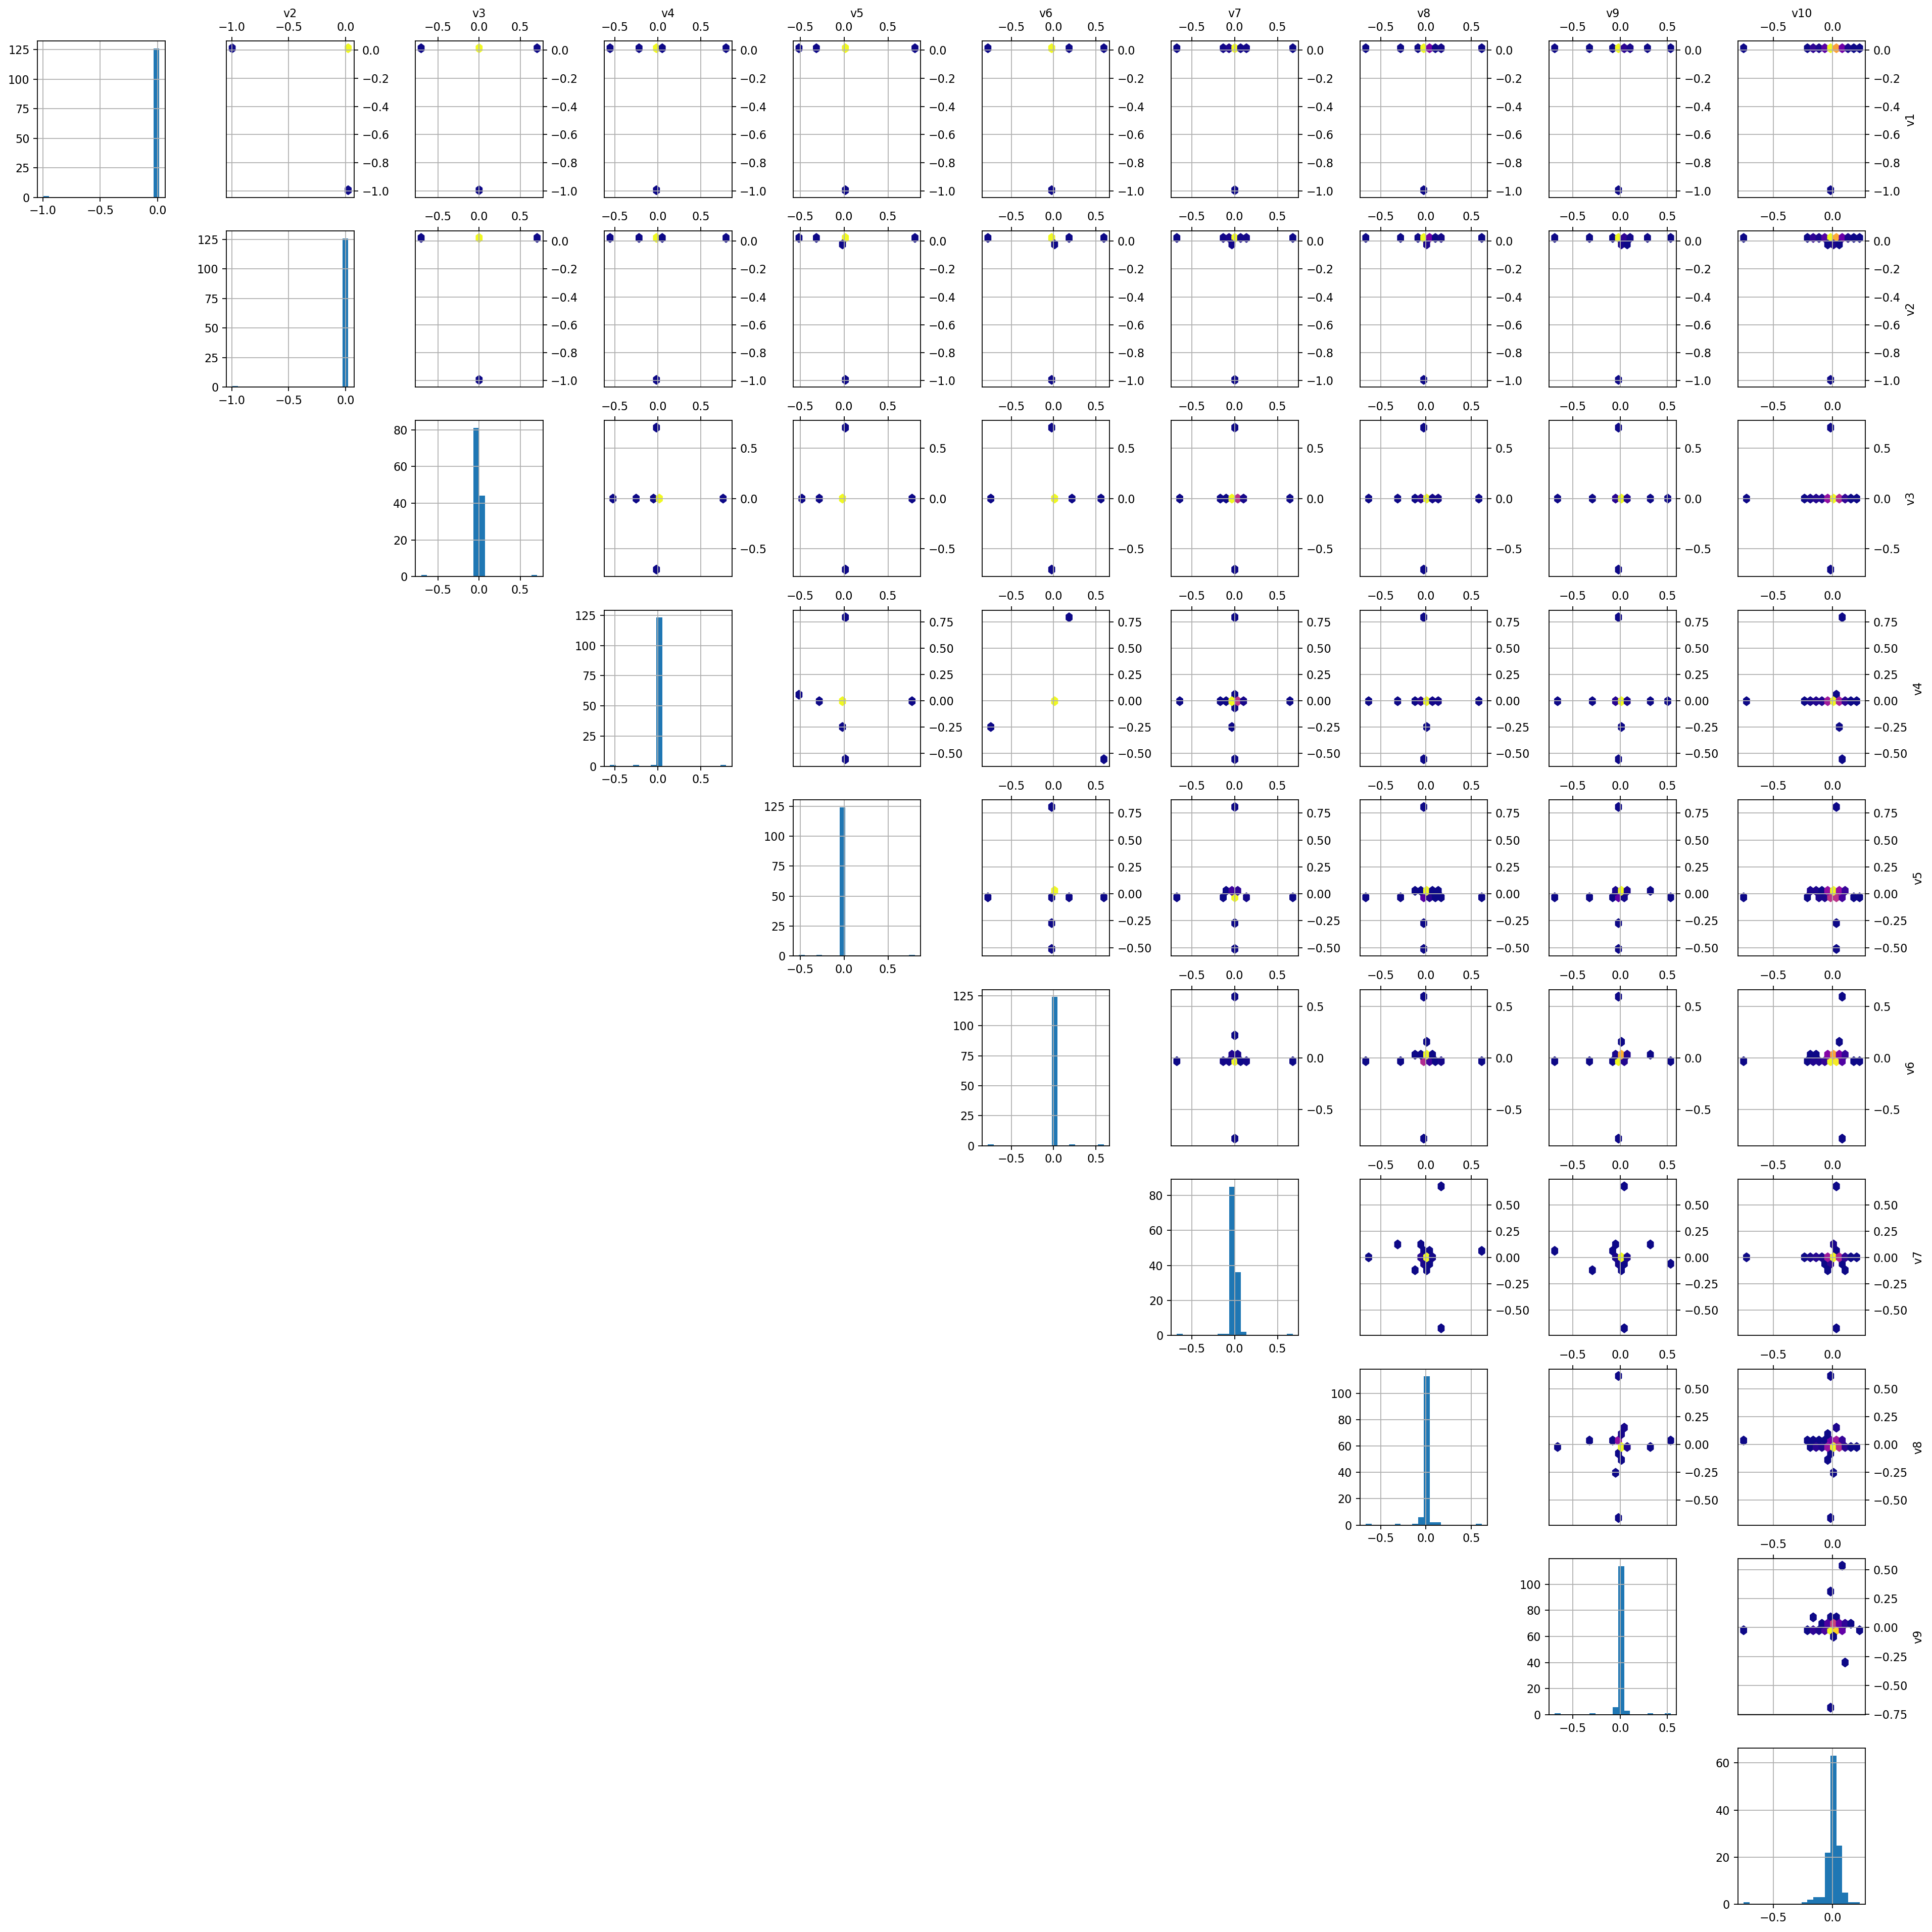

In [16]:
i=0
cmpnt.biplots(x_ica[:,i:len(ids)],n=n_ICA,nbins=20,figsize=(24,24))

**< obsolete comment >** It would seem that this is consistent with the result of ICA on the whole spectrum. Each IC seems to orient itself along directions that pick up on outliers. Given that projections are normalized, we might have a way to remove outliers by carefully scraping off any point that lies beyond some threshold in the IC space. Applying this iteratively, one could hope to reach convergence when no more point is removed. However, what actually seems to happen is that ICs orient themselves with individual points, sort of inverting what PCA had been doing; this would explain why all components have the same negentropy.**</ obsolete comment >**

In [18]:
#for i in np.arange(len(ids)):
#    print(np.min(abs(x_ica[i,:])),np.max(abs(x_ica[i,:])))